# Collecting 1-Second Interval Fitbit Heart Rate Data for a Range of Dates
To start saving your own data as a CSV, you really only need to adjust the following variables in this notebook:

  * USER_ID, CLIENT_SECRET (your own Fitbit credentials)
  * start_date, end_date (dates in date range, note end_date is not inclusive)
  * path (specifies where to save your output)

## 1. Import the necessary Python libraries and modules: 

In [165]:
#!/usr/bin/python      
%matplotlib inline

import fitbit
import matplotlib.pyplot as plt
import gather_keys_oauth2 as Oauth2
import numpy as np
import datetime
import pandas as pd
import csv
import re
from IPython.display import display

## 2. Access the Fitbit API
Replace 'your USER_ID' and 'your CLIENT_SECRET' ([follow this tutorial to obtain these](http://blog.mr-but-dr.xyz/en/programming/fitbit-python-heartrate-howto/)) to access your Fitbit data:

In [144]:
"""provide your credentials for OAuth2.0"""
USER_ID = 'your USER_ID' # should look something like this: '123A4B'
CLIENT_SECRET = 'your CLIENT_SECRET' # should look something like this: 'c321fvdc59b4cc62156n9luv20k39072'

"""obtain access and refresh tokens"""
server = Oauth2.OAuth2Server(USER_ID, CLIENT_SECRET)
server.browser_authorize()
 
ACCESS_TOKEN = server.oauth.token['access_token']
REFRESH_TOKEN = server.oauth.token['refresh_token']
 
"""complete authorization"""
auth2_client = fitbit.Fitbit(USER_ID, CLIENT_SECRET, oauth2=True, access_token=ACCESS_TOKEN, refresh_token=REFRESH_TOKEN)

[17/Jul/2016:20:18:32] ENGINE Listening for SIGHUP.
INFO:cherrypy.error:[17/Jul/2016:20:18:32] ENGINE Listening for SIGHUP.
[17/Jul/2016:20:18:32] ENGINE Listening for SIGTERM.
INFO:cherrypy.error:[17/Jul/2016:20:18:32] ENGINE Listening for SIGTERM.
[17/Jul/2016:20:18:32] ENGINE Listening for SIGUSR1.
INFO:cherrypy.error:[17/Jul/2016:20:18:32] ENGINE Listening for SIGUSR1.
[17/Jul/2016:20:18:32] ENGINE Bus STARTING
INFO:cherrypy.error:[17/Jul/2016:20:18:32] ENGINE Bus STARTING
[17/Jul/2016:20:18:32] ENGINE Started monitor thread 'Autoreloader'.
INFO:cherrypy.error:[17/Jul/2016:20:18:32] ENGINE Started monitor thread 'Autoreloader'.
[17/Jul/2016:20:18:32] ENGINE Started monitor thread '_TimeoutMonitor'.
INFO:cherrypy.error:[17/Jul/2016:20:18:32] ENGINE Started monitor thread '_TimeoutMonitor'.
[17/Jul/2016:20:18:32] ENGINE Serving on http://127.0.0.1:8080
INFO:cherrypy.error:[17/Jul/2016:20:18:32] ENGINE Serving on http://127.0.0.1:8080
[17/Jul/2016:20:18:32] ENGINE Bus STARTED
INFO:che

127.0.0.1 - - [17/Jul/2016:20:18:34] "GET /?code=c58094ebedb308ec36f65f04aaec499f2cf6b5f5&state=BhEvba1rieRYQGHae4Mn1I8ZaSnZVu HTTP/1.1" 200 122 "" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36"


## 3. Pick a Date Range
In order to not exceed the rate limit, intervals shorter than 6 months typically work best (learn more about [Fitbit's rate limiting policy]).   

[Fitbit's rate limiting policy]: https://dev.fitbit.com/docs/basics/#rate-limits

In [145]:
start_date = datetime.date(2016, 2, 13)
end_date = datetime.date(2016, 2, 17) # end_date not inclusive

In [146]:
"""function to iterate over dates (resource: http://stackoverflow.com/a/1060330)"""

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)): # for loop through dates in date range
        yield start_date + datetime.timedelta(n) # return date

## 4. Define a path to save your data files to
If you followed the README to create folders to store your data the end of your path will look like mine, otherwise adjust as necessary:

In [147]:
# adjust your path depending on where you want to store your data
path='/Users/amandasolis/Dropbox/Projects/python-fitbit/Data/'

## 5. Define function for data collection
When requesting Heart Rate data at the 1-sec interval, Fitbit actually provides data in 10 or 15 second intervals unless the tracker's "Workout" mode is activated. In any case, this function extracts all heart rate values provided by Fitbit and linearly interpolates missing values.

In [152]:
"""Heart Rate Time Series Function -- Detail Level = 1 second"""

def HR_SeriesSeconds(start_date, end_date):
    HR_df = pd.DataFrame([]) # initialize an empty data frame
    # create index of all 86400 seconds
    full_index=[]
    for i in range(0,86400):
        sec=str(datetime.timedelta(seconds=i))
        full_index.append(sec.zfill(8)) # pad times to have format 00:00:00 rather than 0:00:00
    for single_date in daterange(start_date, end_date): # loop through dates in date range
        date = single_date.strftime("%Y-%m-%d")
        # access Fitbit heart rate log and save as data frame:
        fitbit_stats = auth2_client.intraday_time_series('activities/heart', base_date=date, detail_level='1sec')
        stats = fitbit_stats['activities-heart-intraday']['dataset']
        HR=pd.DataFrame(stats)
        try: # try the following:
            indexed_HR = HR.set_index(HR['time'])
        except KeyError: # if there is no HR['time'] data for this date, create an empty row:
            filler=pd.DataFrame(np.empty(86400, dtype=object))
            full_filler=filler.reindex(full_index) # reindex with the full_index of times from the Calorieseries function 
            filler=full_filler.transpose()
            filler=filler.rename(index={0: str(date)}) # rename the index (row name) with the corresponding date
            HR_df = HR_df.append(filler, ignore_index=False) # add this row to the data frame initialized before the for loop
        else:
            del indexed_HR['time']
            full_HR=indexed_HR.reindex(full_index) # reindex with the full_index of times
            full_HR=full_HR.interpolate() # interpolate missing values
            full_HR=full_HR.fillna(method='bfill') # back fill rows that start with nan
            HR2=full_HR.transpose()
            HR2=HR2.rename(index={'value': str(date)}) # rename the index (row name) with the corresponding date
            HR_df = HR_df.append(HR2, ignore_index=False) # add this row to the data frame initialized before the for loop
    
    # the 'name' variable reflects the folder and file name we are saving the full data frame to:
    name='HR_Second_Timeseries/HR_Second_Timeseries_', str(start_date),'.csv'
    name="".join(name)
    # adding in the full path saves the file to the exact location specified earlier:
    full_path=path, name
    full_path="".join(full_path)
    HR_df.to_csv(full_path)
    
    # save 'HR_df1' as a global variable to explore directly in this notebook
    global HR_Seconds_df1
    HR_Seconds_df1 = HR_df
    return HR_Seconds_df1

## 6. Run HR_SeriesSeconds and Explore CSV File/Global Variable! 

In [164]:
HR_SeriesSeconds(start_date,end_date) # obtain heart rate time-series data

time,00:00:00,00:00:01,00:00:02,00:00:03,00:00:04,00:00:05,00:00:06,00:00:07,00:00:08,00:00:09,...,23:59:50,23:59:51,23:59:52,23:59:53,23:59:54,23:59:55,23:59:56,23:59:57,23:59:58,23:59:59
2016-02-13,59,59,59,59,59,59,59.0,59.0,59.0,59.0,...,58,58,58,58,58,58,58,58,58,58
2016-02-14,58,58,58,58,58,58,58.2,58.4,58.6,58.8,...,63,63,63,63,63,63,63,63,63,63
2016-02-15,62,62,62,62,62,62,62.2,62.4,62.6,62.8,...,74,74,74,74,74,74,74,74,74,74
2016-02-16,73,73,73,73,73,73,73.0,73.0,73.0,73.0,...,54,54,54,54,54,54,54,54,54,54


## 7. Plot Heart Rate Time Series

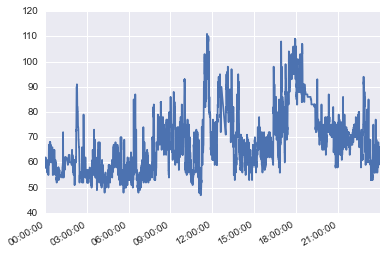

In [168]:
time=pd.to_datetime(full_index)
plt.plot(time, HR_Seconds_df1.iloc[1]) # plot one date of heart rate data
plt.gcf().autofmt_xdate()